In [52]:
#Computação científica
import numpy as np

#análise de dados
import pandas as pd

#machine learning
from sklearn.linear_model import LogisticRegression #regressão lasso
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score
import lightgbm as lgb

#visualização
import matplotlib.pyplot as plt
import seaborn as sns

#sampling
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

#Parâmetros

In [2]:
#Definir a seed para que os resultados obtidos sejam sempre os mesmos

seed=0

In [23]:
#Estilo dos gráficos do seaborn

sns.set_theme(style="darkgrid")


# Carregar *Dados*

In [4]:
path='/content/drive/MyDrive/Rodolfo/porto/porto-seguro-safe-driver-prediction/'



In [6]:
#Dados com todas as colunas:
#Usarei somente os dados com as colunas selecionadas

#x_train_complete = pd.read_csv(path+'train_complete_transformed.csv')
#x_val_complete   = pd.read_csv(path+'val_complete_transformed.csv')

#y_train = pd.read_csv(path+'y_train.csv')
#y_val   = pd.read_csv(path+'y_val.csv')


In [5]:
x_train_selected = pd.read_csv(path+'train_selected_features_transformed.csv')
x_val_selected   = pd.read_csv(path+'val_selected_features_transformed.csv')

y_train = pd.read_csv(path+'y_train.csv')
y_val   = pd.read_csv(path+'y_val.csv')

np.shape(x_train_selected)

(476169, 108)

In [7]:
y_train= np.ravel(y_train)
y_val  = np.ravel(y_val)

# Feature Selection com Logistic Regression

Uso da penalidade l1 para que parte dos pesos sejam anulados, e assim seja possível selecionar as features mais importantes. A regressão logistica com penalidade l1 corresponde a regressão lasso.

Buscar melhores valores para a intensidade da regularização. Essa intensidade é controlada pelo parâmetro alpha. Na regressão logística o parâmetro C é o inverso de alpha.

## Dados com todas as features iniciais

In [ ]:
##Gridsearch para buscar o melhor valor de C
'''
alpha=[10**x for x in range(1,-4,-1)]
alpha
params={'C':[1/x for x in alpha]}

# Number of Folds and adding the random state for replication
kf=KFold(n_splits=3,shuffle=True, random_state=seed)

clf = LogisticRegression(random_state=seed,penalty='l1',max_iter=1000,solver='saga')
clf_cv=GridSearchCV(clf, param_grid=params, cv=kf)
clf_cv.fit(train_todas_colunas, y_train_one_dimension)
print("Best Params {}".format(clf_cv.best_params_))
'''

'\nalpha=[10**x for x in range(1,-4,-1)]\nalpha\nparams={\'C\':[1/x for x in alpha]}\n\n# Number of Folds and adding the random state for replication\nkf=KFold(n_splits=3,shuffle=True, random_state=seed)\n\nclf = LogisticRegression(random_state=seed,penalty=\'l1\',max_iter=1000,solver=\'saga\')\nclf_cv=GridSearchCV(clf, param_grid=params, cv=kf)\nclf_cv.fit(train_todas_colunas, y_train_one_dimension)\nprint("Best Params {}".format(clf_cv.best_params_))\n'

In [31]:
clf = LogisticRegression(random_state=seed,penalty='l1',C=0.1,solver='saga',max_iter=1000)
clf.fit(x_train_selected,y_train)

LogisticRegression(C=0.1, max_iter=1000, penalty='l1', random_state=0,
                   solver='saga')

In [32]:
# Calculate métricas
y_pred = clf.predict(x_train_selected)
accuracy = accuracy_score( y_train,y_pred)
precision= precision_score( y_train,y_pred)
recall   =recall_score( y_train,y_pred)
print(f"Model Accuracy: {accuracy:.2f}")
print(f"Model Precision: {precision:.2f}")
print(f"Model Recall:    {recall:.2f}")


Model Accuracy: 0.96
Model Precision: 0.00
Model Recall:    0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [33]:
# Valores dos coeficientes da regressão
coefficients = clf.coef_[0]

#criação de um dataframe com os valores dos coeficientes da regressão
feature_importance_lr = pd.DataFrame({
    'Feature': x_train_selected.columns,
    'Coefficient': coefficients})

In [34]:
#ordenar os coeficientes de acordo com os maiores valores absolutos
feature_importance_lr['Coefficient']=feature_importance_lr['Coefficient'].abs()
feature_importance_lr.sort_values(by='Coefficient',ascending=False,inplace=True)

In [35]:
feature_importance_lr['Coefficient'].describe()

,Coefficient
count,108.000000
mean,0.066284
std,0.082182
min,0.000000
25%,0.000000
50%,0.040043
75%,0.104372
max,0.457641


In [37]:
#32 dos 108 coeficientes foram anulados
(feature_importance_lr['Coefficient']==0).sum()

32

<Axes: xlabel='Coefficient'>

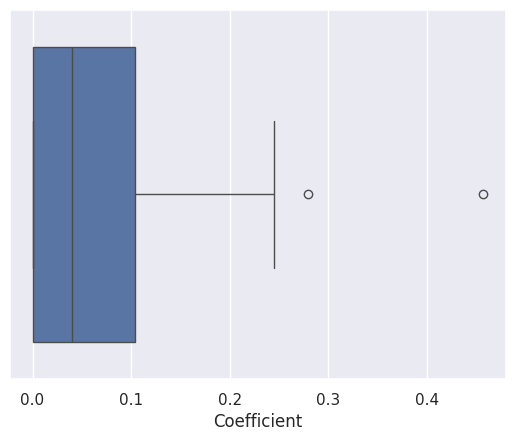

In [38]:
#BoxPlot com valores dos coeficientes
sns.boxplot(data=feature_importance_lr,x='Coefficient')

<Axes: xlabel='Coefficient', ylabel='Feature'>

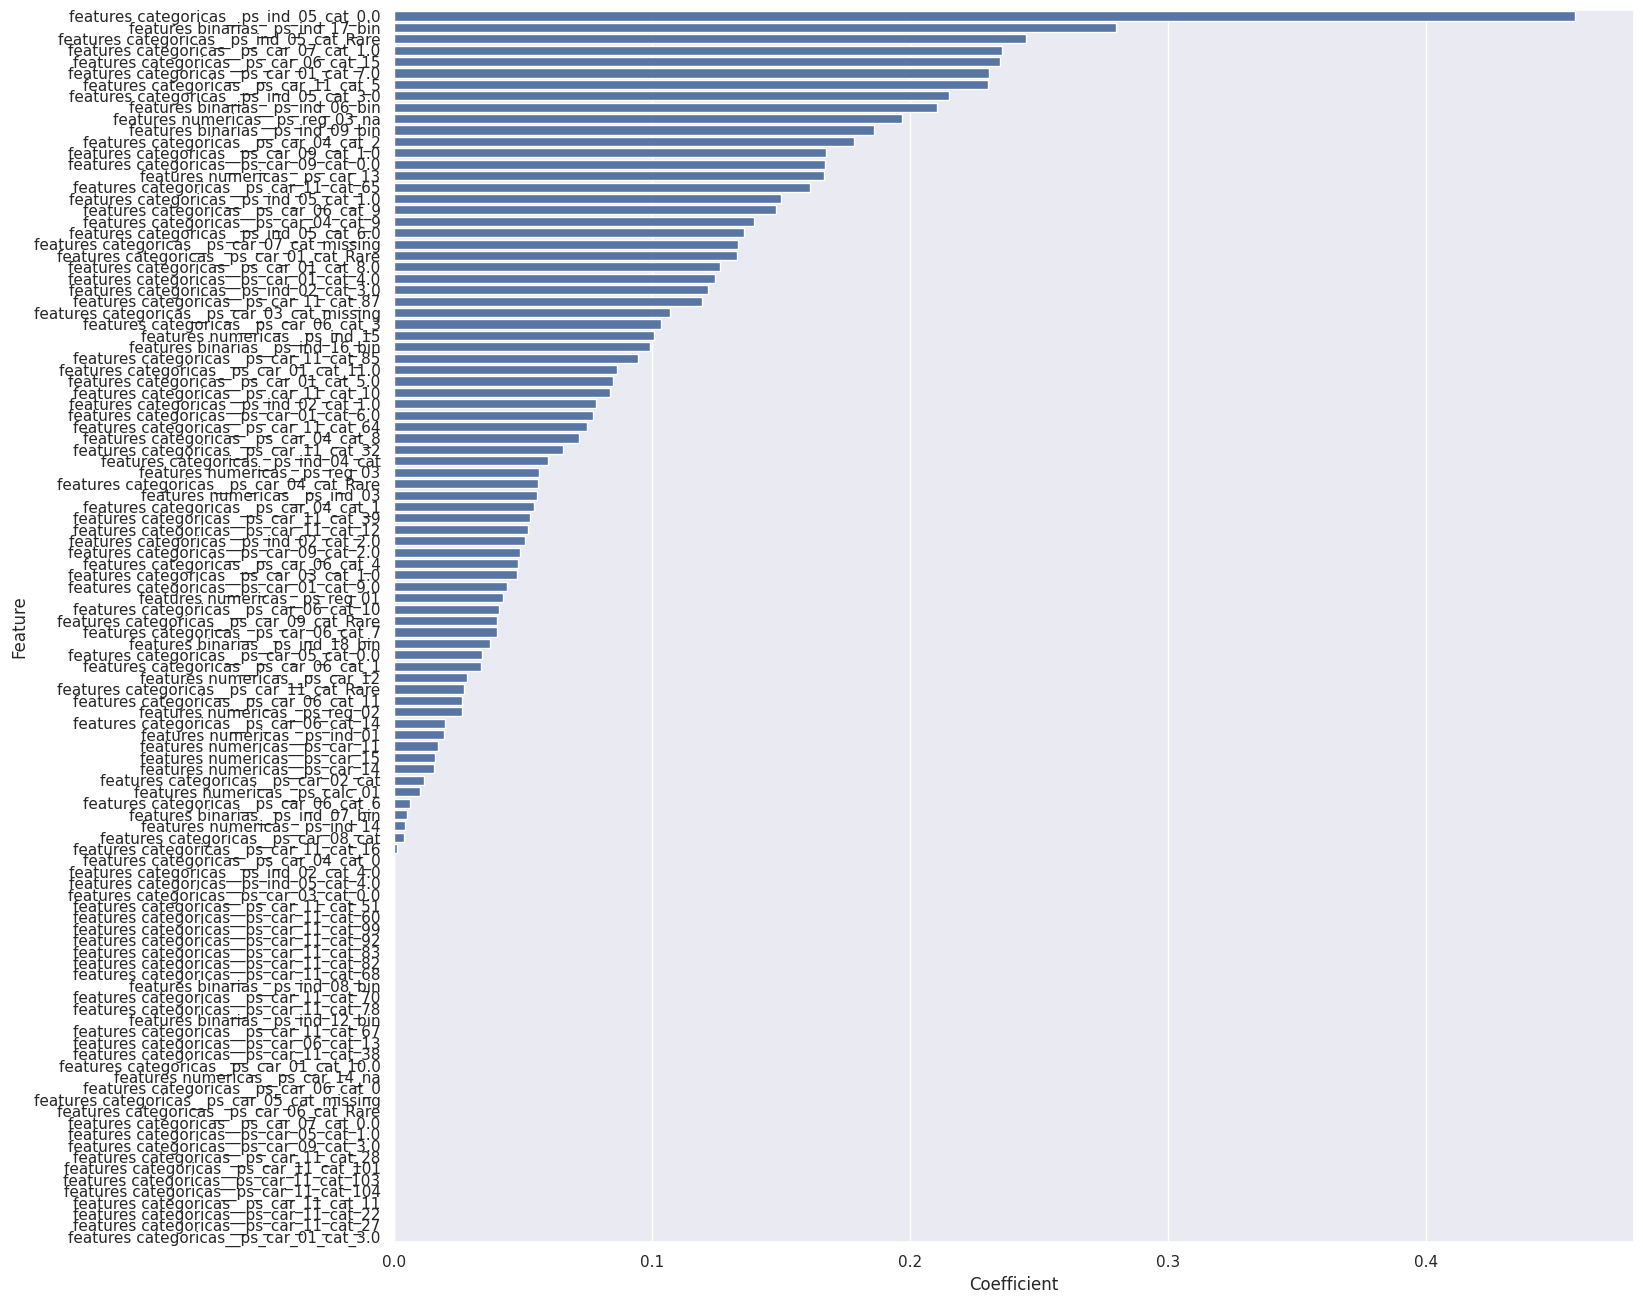

In [39]:
plt.figure(figsize=(16,16))
sns.barplot(x='Coefficient',y='Feature',data=feature_importance_lr,orient='h')

In [45]:
#Selecionar features
threshold_lr = feature_importance_lr['Coefficient'].median() #definição de um threhold
selected_features_lr = feature_importance_lr.loc[feature_importance_lr['Coefficient']>threshold_lr,'Feature'] # features com coeficientes inferiores oa thresold definido
                                                                                                         # não serão usadas
selected_features_lr = selected_features_lr.to_list()

In [46]:
#Número de features selecionadas usando os coeficientes da regressão logística
print('Número de features selecionadas: {}'.format(len(selected_features_lr)))

Número de features selecionadas: 54


In [48]:
x_train_lr=x_train_selected.loc[:,selected_features_lr]
x_val_lr  =x_val_selected.loc[:,selected_features_lr]

## Sampling

Duas estratégias:


1.   Random Undersampling seguido de OverSampling com Smote;
2.   Combinação de Smote Oversampling com TomekLinks Undersampling.



### Random Undersampling seguido de Oversampling com Smote

In [51]:
#Razão entre o número de amostras da classe majoritária e da classe minoritária
np.sum(y_train==0)/np.sum(y_train==1)

26.436992221261885

In [ ]:
ru_lr=RandomUnderSampler()

# Feature Selection com LightGBM

In [ ]:
model = lgb.LGBMClassifier(importance_type='gain',n_estimators=500)


In [ ]:
y_train=np.ravel(y_train)

In [ ]:
model.fit(x_train_selected,y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274764
[LightGBM] [Info] Start training from score -3.274764


LGBMClassifier(importance_type='gain', n_estimators=500)

In [ ]:
gain_importance = model.feature_importances_


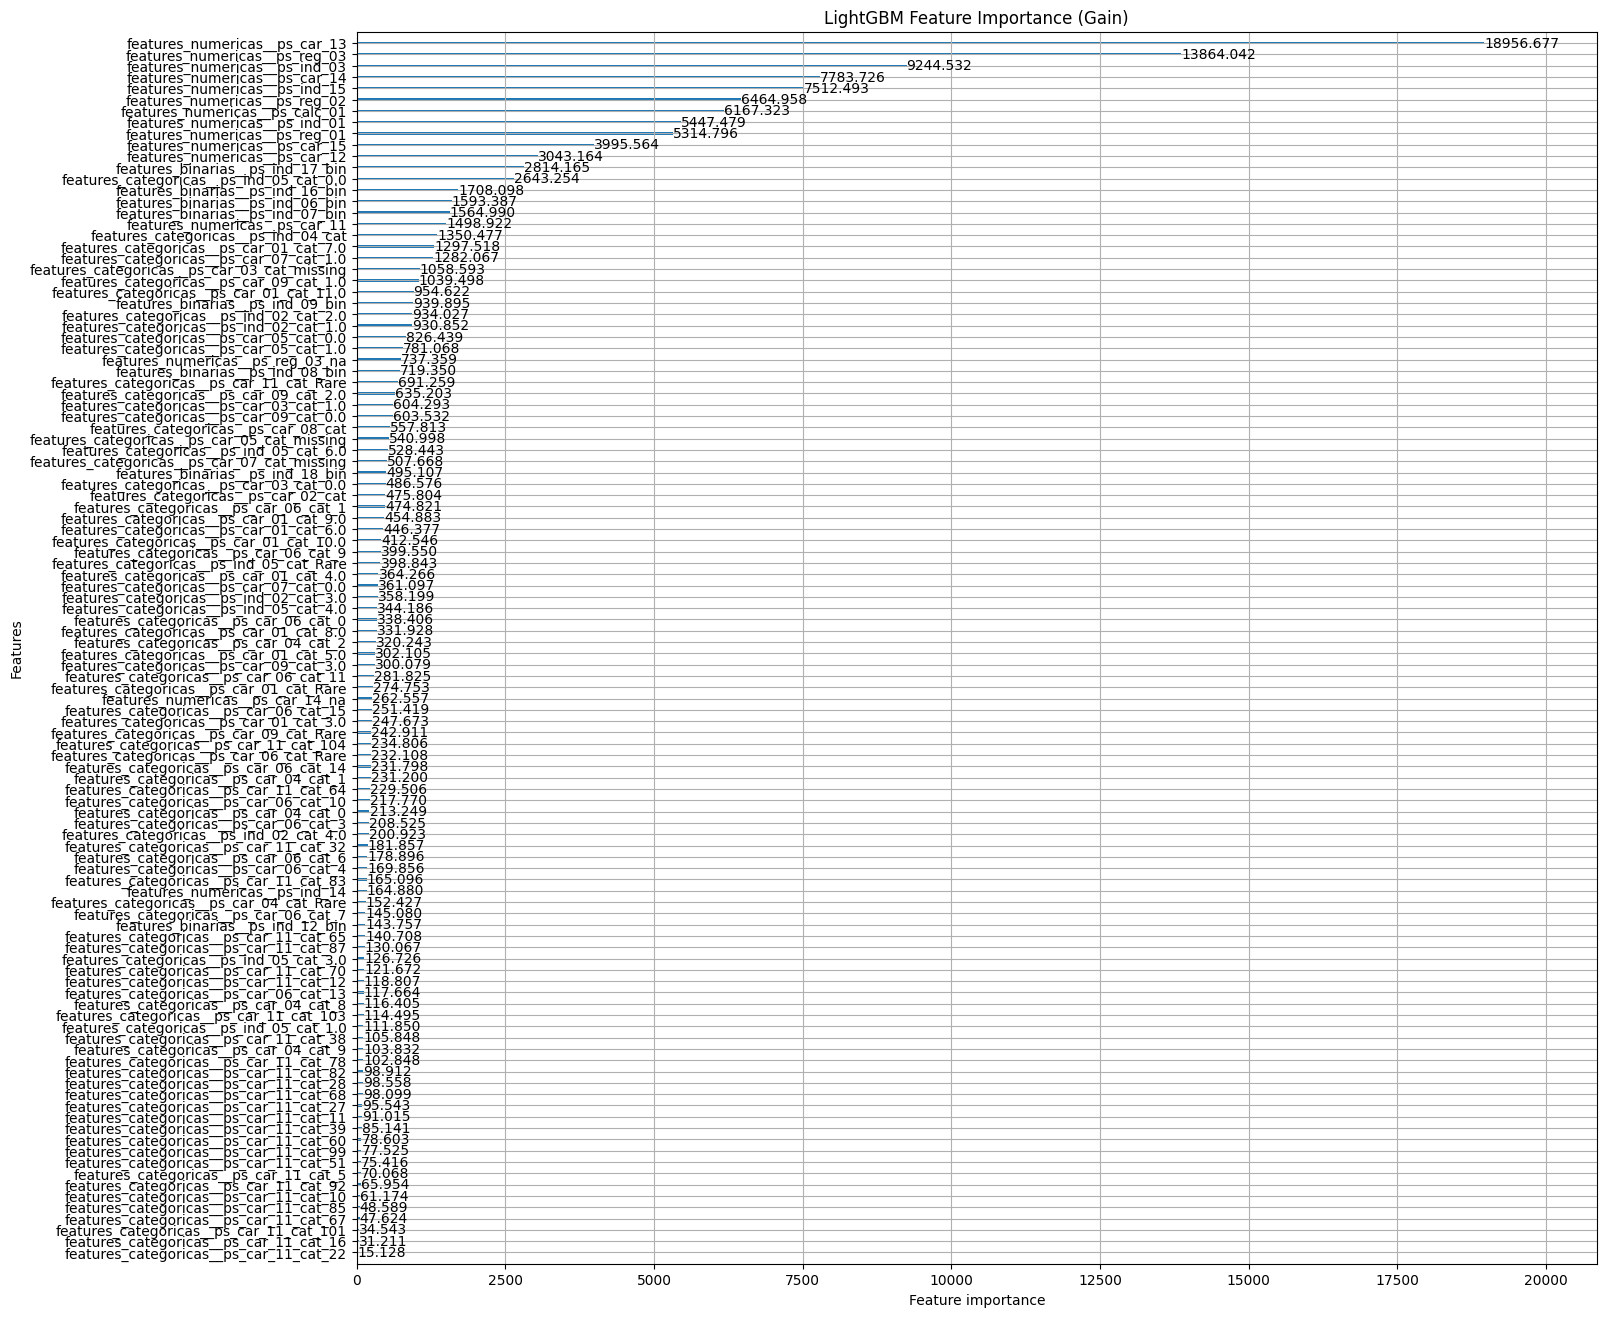

In [ ]:
lgb.plot_importance(model, importance_type="gain", figsize=(16,16), title="LightGBM Feature Importance (Gain)")
plt.show()

In [ ]:
#https://mariofilho.com/lightgbm-tuning-hiperparametros-optuna/

In [ ]:
from imblearn.combine import SMOTETomek


In [ ]:
smote_tomek=SMOTETomek()

In [ ]:
x_smote,y_smote=smote_tomek.fit_resample(x_train_selected.loc[:,colunas],y_train)

In [ ]:
modelo_teste=lgb.LGBMClassifier(max_depth=5,
                           n_estimators=500)

In [ ]:
from sklearn.model_selection import cross_validate


In [ ]:
modelo_teste.fit(x_smote,y_smote)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 458798, number of negative: 458798
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.108135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9973
[LightGBM] [Info] Number of data points in the train set: 917596, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

LGBMClassifier(max_depth=5, n_estimators=500)

In [ ]:
y_pred=modelo_teste.predict(x_smote)


In [ ]:
y_pred=np.where(y_pred>0.5,1,0)

In [ ]:
accuracy_score(y_smote,y_pred)


0.5011137653551407

In [ ]:
precision= precision_score( y_smote,y_pred)
recall   =recall_score( y_smote,y_pred)

In [ ]:
recall

0.002231889870184218

In [ ]:
precision

0.9980506822612085

In [ ]:
teste=pd.DataFrame({'Feature':x_train_selected.columns,'Feature Importance':gain_importance})

In [ ]:
teste.describe()

,Feature Importance
count,108.000000
mean,1218.985716
std,2737.374441
min,15.127520
25%,129.231924
50%,311.174336
75%,792.411023
max,18956.676820


In [ ]:
teste.sort_values(by='Feature Importance',ascending=False)

,Feature,Feature Importance
17,features numericas__ps_car_13,18956.676820
14,features numericas__ps_reg_03,13864.041510
9,features numericas__ps_ind_03,9244.531943
18,features numericas__ps_car_14,7783.726005
11,features numericas__ps_ind_15,7512.492518
...,...,...
103,features categoricas__ps_car_11_cat_85,48.589074
97,features categoricas__ps_car_11_cat_67,47.623770
80,features categoricas__ps_car_11_cat_101,34.543020
85,features categoricas__ps_car_11_cat_16,31.210613


In [ ]:
teste['selecionar']=teste['Feature Importance']>150

In [ ]:
teste=teste[teste['selecionar']]

In [ ]:
colunas=teste['Feature'].to_list()

In [ ]:
colunas=teste.iloc[:50,0].to_list()

In [ ]:
colunas

['features binarias__ps_ind_06_bin',
 'features binarias__ps_ind_07_bin',
 'features binarias__ps_ind_08_bin',
 'features binarias__ps_ind_09_bin',
 'features binarias__ps_ind_16_bin',
 'features binarias__ps_ind_17_bin',
 'features binarias__ps_ind_18_bin',
 'features numericas__ps_ind_01',
 'features numericas__ps_ind_03',
 'features numericas__ps_ind_14',
 'features numericas__ps_ind_15',
 'features numericas__ps_reg_01',
 'features numericas__ps_reg_02',
 'features numericas__ps_reg_03',
 'features numericas__ps_car_11',
 'features numericas__ps_car_12',
 'features numericas__ps_car_13',
 'features numericas__ps_car_14',
 'features numericas__ps_car_15',
 'features numericas__ps_calc_01',
 'features numericas__ps_reg_03_na',
 'features numericas__ps_car_14_na',
 'features categoricas__ps_ind_04_cat',
 'features categoricas__ps_car_02_cat',
 'features categoricas__ps_car_08_cat',
 'features categoricas__ps_ind_02_cat_1.0',
 'features categoricas__ps_ind_02_cat_2.0',
 'features categ

In [ ]:
model.fit(x_train_selected.loc[:,colunas],y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1067
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274764
[LightGBM] [Info] Start training from score -3.274764


LGBMClassifier(importance_type='gain', n_estimators=500)

In [ ]:
y_pred=model.predict(x_train_selected.loc[:,colunas])
#y_pred=model.predict(x_train_selected)

In [ ]:
y_pred=np.where(y_pred>0.5,1,0)

In [ ]:
accuracy_score( y_train,y_pred)


0.9638699705356711

In [ ]:
accuracy = accuracy_score( y_train,y_pred)
precision= precision_score( y_train,y_pred)
recall   =recall_score( y_train,y_pred)

In [ ]:
accuracy

0.9639266730929565

In [ ]:
precision

0.989010989010989

In [ ]:
recall

0.010371650821089023

In [ ]:
sum(y_train)

17355

In [ ]:
sum(y_pred)

145

In [ ]:
#https://www.geeksforgeeks.org/lightgbm-feature-importance-and-visualization/